# Cats & Dogs

Discriminate between Cats and Dogs in images

#### Imports & Configurations

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os,shutil
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

from keras import layers
from keras import models
import tensorflow as tf

from keras import optimizers
from keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

tf.debugging.set_log_device_placement(True)

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
base_dir = "./data"
train_dir = "./data/train"
test_dir = "./data/test1"

print(os.listdir(base_dir))

['sampleSubmission.csv', 'train']


## Preparing TRAIN dataset

Images in `./data/train` folder has a "class-aware" naming convention:

`[dog|cat].<image_number>.jpg`

Let's create the pandas DataFrame accordingly

In [3]:
train_imagenames = os.listdir(train_dir)
image_name = []
image_paths = []

for imagename in train_imagenames:
    image = imagename.split('.')[0]
    image_path = os.path.join(train_dir, imagename)
    image_paths.append(image_path)
    image_name.append(image)
    
image_df = pd.DataFrame()

image_df["image_path"] = image_paths
image_df["image_name"] = image_name

In [4]:
image_df.head()

,image_path,image_name
0,./data/train/cat.1974.jpg,cat
1,./data/train/dog.8461.jpg,dog
2,./data/train/cat.10441.jpg,cat
3,./data/train/cat.3251.jpg,cat
4,./data/train/dog.1807.jpg,dog


In [5]:
image_df["image_name"].value_counts()

cat    12500
dog    12500
Name: image_name, dtype: int64

### Checking GPUs

In [6]:
tf.debugging.set_log_device_placement(True)

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Neural Net Architecture

### Custom CNN

In [8]:
with tf.device('GPU:1'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.summary()
    
    model.compile(loss = "binary_crossentropy", optimizer = RMSprop(lr=1e-4), metrics = ["acc"])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
____

### Train/Validation Split

 - 80% Train
 - 20% Validation

In [9]:
train, validation = train_test_split(image_df,test_size=0.2, random_state=42) 

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2,
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(train, x_col = "image_path", y_col = "image_name", target_size = (150, 150), batch_size = 128, class_mode = "binary")
validation_generator = validation_datagen.flow_from_dataframe(validation, x_col = "image_path", y_col = "image_name", target_size = (150, 150), batch_size = 128, class_mode = "binary")


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Training

 -  40 Epochs
 -  80 Steps per Epoch
 - 200 Validation Steps

In [11]:
history = model.fit_generator(train_generator,
                             steps_per_epoch = 80, epochs = 40, validation_data = validation_generator, validation_steps = 200)

Epoch 1/40
80/80 [==============================] - 126s 2s/step - loss: 0.6909 - acc: 0.5251 - val_loss: 0.6836 - val_acc: 0.5778
Epoch 2/40
80/80 [==============================] - 121s 2s/step - loss: 0.6807 - acc: 0.5625 - val_loss: 0.6951 - val_acc: 0.5216
Epoch 3/40
80/80 [==============================] - 120s 2s/step - loss: 0.6668 - acc: 0.5988 - val_loss: 0.6544 - val_acc: 0.6136
Epoch 4/40
80/80 [==============================] - 121s 2s/step - loss: 0.6612 - acc: 0.6061 - val_loss: 0.6853 - val_acc: 0.5714
Epoch 5/40
80/80 [==============================] - 120s 2s/step - loss: 0.6546 - acc: 0.6118 - val_loss: 0.6680 - val_acc: 0.5910
Epoch 6/40
80/80 [==============================] - 120s 2s/step - loss: 0.6483 - acc: 0.6247 - val_loss: 0.7102 - val_acc: 0.5482
Epoch 7/40
80/80 [==============================] - 120s 2s/step - loss: 0.6413 - acc: 0.6311 - val_loss: 0.6266 - val_acc: 0.6518
Epoch 8/40
80/80 [==============================] - 121s 2s/step - loss: 0.6323 - a

### Metrics

 - Loss & Accuracy ...
 - ... on Training set ...
 - ... and on Validation set (to catch eventual overfitting)

<Figure size 432x288 with 0 Axes>

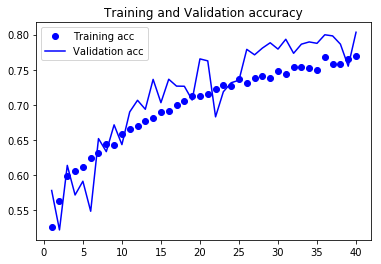

<Figure size 432x288 with 0 Axes>

In [12]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label = "Training acc")
plt.plot(epochs, val_acc, "b", label = "Validation acc")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

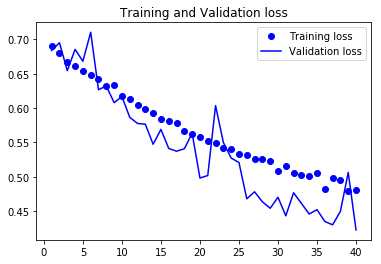

In [13]:
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()